In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Scalable_project

/content/drive/My Drive/Scalable_project


In [3]:
!ls
!pwd

Dataset_Challenge_Dataset_Agreement.pdf  yelp_business_hours.csv  YelpReviews_.ipynb
yelp_business_attributes.csv		 yelp_checkin.csv	  yelp_tip.csv
yelp_business.csv			 yelp_review.csv	  yelp_user.csv
/content/drive/My Drive/Scalable_project


In [4]:
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz

# Installing the library to install the spark in python
!pip install -q findspark
!pip install pyspark

tar: spark-3.1.2-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=1ec405039eb10dcce8483c7614b21b4ebd22d1a0909477526d0e53cb70ad19f9
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [5]:
!pip install pyspark  # Install PySpark if necessary

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, length
from pyspark.sql.types import IntegerType, StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Start Spark session with increased memory allocation
spark = SparkSession.builder \
    .appName("Yelp Sentiment Analysis") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()


In [6]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, TimestampType

# Define schemas based on the information you provided
review_schema = StructType([
    StructField("review_id", StringType()),
    StructField("user_id", StringType()),
    StructField("business_id", StringType()),
    StructField("stars", IntegerType()),
    StructField("date", TimestampType()),
    StructField("text", StringType()),
    StructField("useful", IntegerType()),
    StructField("funny", IntegerType()),
    StructField("cool", IntegerType())
])

business_schema = StructType([
    StructField("business_id", StringType()),
    StructField("name", StringType()),
    StructField("neighborhood", StringType()),
    StructField("address", StringType()),
    StructField("city", StringType()),
    StructField("state", StringType()),
    StructField("postal_code", StringType()),
    StructField("latitude", DoubleType()),
    StructField("longitude", DoubleType()),
    StructField("stars", DoubleType()),
    StructField("review_count", IntegerType()),
    StructField("is_open", IntegerType()),
    StructField("categories", StringType())
])

user_schema = StructType([
    # Include your user schema here similarly
])

# Load datasets
yelp_review = spark.read.csv('/content/drive/My Drive/Scalable_project/yelp_review.csv', schema=review_schema, header=True)
yelp_business = spark.read.csv('/content/drive/My Drive/Scalable_project/yelp_business.csv', schema=business_schema, header=True)
yelp_user = spark.read.csv('/content/drive/My Drive/Scalable_project/yelp_user.csv', schema=user_schema, header=True)



Here is a step-by-step guide with PySpark code for each of the tasks you outlined:

1. Top 'Most Reviewed' Businesses

In [7]:
from pyspark.sql.functions import desc

# Most reviewed businesses
most_reviewed_businesses = yelp_business.orderBy(desc("review_count")).limit(10)
most_reviewed_businesses.show()


+--------------------+--------------------+---------------+--------+--------------------+--------------------+--------------------+--------+---------+-----+------------+-------+--------------+
|         business_id|                name|   neighborhood| address|                city|               state|         postal_code|latitude|longitude|stars|review_count|is_open|    categories|
+--------------------+--------------------+---------------+--------+--------------------+--------------------+--------------------+--------+---------+-----+------------+-------+--------------+
|9HVfZnKjd85Fy90kV...|"""James Q. Del R...|          FAOCD| FAAD"""|       Spring Valley|     """9097 Post Rd|             Ste 100|    NULL|     NULL| NULL|       89148|   NULL|  -115.2904438|
|n6Osd2cJoFNH21pzu...|    """Kirsten Rojas|             MD|   FACOG|             FACS"""|       Spring Valley|   """9120 W Post Rd|    NULL|     NULL| NULL|       89148|   NULL|   -115.291269|
|R58vIa88eZLQojnZT...|             

In [8]:
# Inorder to look at the reviews and their count we filter the data for which star rating is greater than 3
review_filtered = yelp_review.filter('stars >3')
grouped_review = review_filtered.groupby('business_id').count()
sort_review = grouped_review.sort('count',ascending=False)

business_1 = yelp_business.select('business_id','name','categories')
review_business_name = business_1.join(sort_review,'business_id','inner')
business_reviewed = review_business_name.limit(10)
business_reviewed.show()

+--------------------+--------------------+--------------------+-----+
|         business_id|                name|          categories|count|
+--------------------+--------------------+--------------------+-----+
|--6MefnULPED_I942...|"""John's Chinese...|                  37|   17|
|--7zmmkVg-IMGaXbu...|"""Primal Brewery"""|      Food;Breweries|   34|
|--9QQLMTbFzLJ_oT-...|   """Great Clips"""|                   1|    6|
|--9e1ONYQuAa-CB_R...|"""Delmonico Stea...|Cajun/Creole;Stea...| 1104|
|--DaPTJW3-tB1vP-P...|"""Sunnyside Gril...|Restaurants;Break...|   25|
|--EF5N7P70J_UYBTP...|   """MV Nail Spa"""|Beauty & Spas;Nai...|    1|
|--FLdgM0GNpXVMn74...|"""Welch Physical...|                   6|    4|
|--I7YYLada0tSLkOR...|"""Happy Moose Ba...|Restaurants;Sport...|   41|
|--LY7PrnEegglB7vn...|"""International ...|                   1|    8|
|--R3uiY2dB43Mpdwt...|"""Don Valley Nor...|                   1|    6|
+--------------------+--------------------+--------------------+-----+



2. Count of Top Business Categories/Industries

In [9]:
from pyspark.sql.functions import explode, split

# Split the categories string into individual categories
yelp_business = yelp_business.withColumn("category", explode(split("categories", ", ")))

# Count the number of businesses per category
category_counts = yelp_business.groupBy("category").count().orderBy(desc("count"))
category_counts.show()


+--------------------+-----+
|            category|count|
+--------------------+-----+
|                   1|36925|
|                   0| 7292|
|   Restaurants;Pizza|  840|
|   Pizza;Restaurants|  827|
|   Food;Coffee & Tea|  813|
| Mexican;Restaurants|  761|
|   Coffee & Tea;Food|  725|
| Restaurants;Mexican|  720|
| Restaurants;Chinese|  661|
|                   3|  627|
| Chinese;Restaurants|  623|
|Beauty & Spas;Nai...|  570|
|Nail Salons;Beaut...|  568|
|Beauty & Spas;Hai...|  531|
| Restaurants;Italian|  524|
| Italian;Restaurants|  504|
|        Food;Grocery|  500|
|        Grocery;Food|  494|
|Hair Salons;Beaut...|  486|
|Auto Repair;Autom...|  445|
+--------------------+-----+
only showing top 20 rows



3. Count of Different Star Ratings in Our Dataset

In [10]:
star_counts = yelp_review.groupBy("stars").count().orderBy("stars")
star_counts.show()


+-----+-------+
|stars|  count|
+-----+-------+
| NULL|5360250|
|    0|1110530|
|    1|1076417|
|    2| 588297|
|    3| 692015|
|    4|1267260|
|    5|2280944|
|    6|  18568|
|    7|  12945|
|    8|   9384|
|    9|   6992|
|   10|   5409|
|   11|   4003|
|   12|   3204|
|   13|   2516|
|   14|   2109|
|   15|   1718|
|   16|   1364|
|   17|   1145|
|   18|   1059|
+-----+-------+
only showing top 20 rows



In [11]:
rating = yelp_business.select('stars')
group_rating = rating.groupby('stars').count()
rating_top = group_rating.sort('count',ascending=False)
rating_top = rating_top.show(truncate=False)



+------------+-----+
|stars       |count|
+------------+-----+
|4.0         |24818|
|3.5         |24323|
|3.0         |18085|
|4.5         |17224|
|5.0         |16503|
|2.5         |12621|
|2.0         |7377 |
|1.5         |3411 |
|1.0         |2848 |
|NULL        |61   |
|-111.9294198|33   |
|-111.964485 |24   |
|-115.146372 |22   |
|-115.1963237|21   |
|-115.1715512|21   |
|-115.1690207|20   |
|-115.1711298|20   |
|-111.9836094|19   |
|-115.136389 |19   |
|-115.1714113|19   |
+------------+-----+
only showing top 20 rows



4. Top Cities with Maximum Number of Businesses

In [12]:
city_counts = yelp_business.groupBy("city").count().orderBy(desc("count"))
city_counts.show()


+-----------+-----+
|       city|count|
+-----------+-----+
|  Las Vegas|16112|
|    Toronto|14595|
|    Phoenix|11967|
|  Charlotte| 5986|
| Pittsburgh| 5771|
|   Montréal| 5223|
| Scottsdale| 4327|
|       Mesa| 3629|
|  Edinburgh| 3148|
|  Cleveland| 3069|
|    Madison| 2868|
|  Henderson| 2561|
|      Tempe| 2551|
|   Chandler| 2237|
|   Glendale| 1999|
|Mississauga| 1998|
|  Stuttgart| 1902|
|    Gilbert| 1661|
| Ste 100"""| 1587|
| Ste 101"""| 1540|
+-----------+-----+
only showing top 20 rows



In [13]:
locations = yelp_business.select('business_id','city')
review_city = yelp_review.select('business_id')
merge_city = locations.join(review_city,'business_id','inner')
grouped_review_city = merge_city.groupby('city').count()
most_reviewed_city = grouped_review_city.groupby('city').sum()
most_reviewed_city.sort('sum(count)',ascending=False).show(10)

+----------+----------+
|      city|sum(count)|
+----------+----------+
| Las Vegas|   1028279|
|   Phoenix|    425570|
|   Toronto|    384589|
|Scottsdale|    189792|
|Pittsburgh|    172156|
| Charlotte|    171659|
|  Montréal|    116357|
|     Tempe|    103529|
| Henderson|     97396|
| Cleveland|     87701|
+----------+----------+
only showing top 10 rows



5. Number of Reviews per Star Rating

In [14]:
# This is similar to task 3, already provided above
star_counts.show()


+-----+-------+
|stars|  count|
+-----+-------+
| NULL|5360250|
|    0|1110530|
|    1|1076417|
|    2| 588297|
|    3| 692015|
|    4|1267260|
|    5|2280944|
|    6|  18568|
|    7|  12945|
|    8|   9384|
|    9|   6992|
|   10|   5409|
|   11|   4003|
|   12|   3204|
|   13|   2516|
|   14|   2109|
|   15|   1718|
|   16|   1364|
|   17|   1145|
|   18|   1059|
+-----+-------+
only showing top 20 rows



In [15]:
#yelp_review_1= yelp_review.groupBy('stars').agg(count('review_id').alias('count')).sort('stars').show()

6. Plotting the Count of Each Star Rating

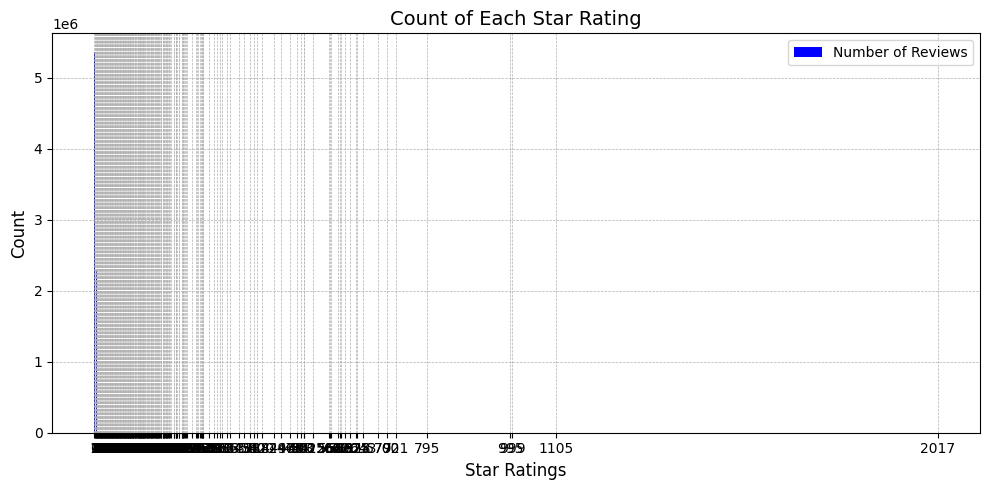

In [16]:
import matplotlib.pyplot as plt

# Collect the data
result = star_counts.collect()

# Prepare data for plotting
ratings = [int(row['stars']) if row['stars'] is not None else 0 for row in result]
counts = [int(row['count']) for row in result]

# Plotting
plt.figure(figsize=(10, 5))
bars = plt.bar(ratings, counts, color='blue')
plt.xlabel('Star Ratings', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Count of Each Star Rating', fontsize=14)
plt.xticks(sorted(set(ratings)), fontsize=10)  # Sorting and setting ratings for x-axis

# Adding a legend if necessary
plt.legend([bars], ['Number of Reviews'], fontsize=10, loc='upper right')

# Improve overall aesthetics
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap

plt.show()


Check for Null Values and Handle Them

In [17]:
from pyspark.sql.functions import col

# Check for null values in all columns of yelp_review
for column in yelp_review.columns:
    print(f"Nulls in {column}: ", yelp_review.filter(col(column).isNull()).count())

# Handling nulls: Assuming replacing null text in reviews with empty string
yelp_review = yelp_review.na.fill({'text': ''})


Nulls in review_id:  203
Nulls in user_id:  2079178
Nulls in business_id:  3165175
Nulls in stars:  5360250
Nulls in date:  7193021
Nulls in text:  6135851
Nulls in useful:  9233741
Nulls in funny:  9306487
Nulls in cool:  9335890


8. Text Preprocessing Including Punctuation Removal, Tokenization, and Stop Word Removal

In [18]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover

# Remove punctuation and tokenize
regex_tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
yelp_review = regex_tokenizer.transform(yelp_review)

# Remove stop words
stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
yelp_review = stop_words_remover.transform(yelp_review)


Sentiment Classification Based on Star Rating (positive if stars > 3)

In [19]:
from pyspark.sql.functions import col, when

# Assuming yelp_review is your DataFrame
# Add a column for sentiment classification
filtered_yelp_review = yelp_review.filter((col("stars") > 3) & (col("stars").isNotNull()))

# Since all remaining rows are greater than 3 stars, we can directly set sentiment as 1
filtered_yelp_review = filtered_yelp_review.withColumn("sentiment", when(col("stars") > 3, 1).otherwise(0))

# Display the DataFrame with the new column
filtered_yelp_review.show()

+--------------------+--------------------+--------------------+-----+-------------------+--------------------+------+-----+----+--------------------+--------------------+---------+
|           review_id|             user_id|         business_id|stars|               date|                text|useful|funny|cool|               words|      filtered_words|sentiment|
+--------------------+--------------------+--------------------+-----+-------------------+--------------------+------+-----+----+--------------------+--------------------+---------+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28 00:00:00|Super simple plac...|  NULL| NULL|NULL|[super, simple, p...|[super, simple, p...|        1|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28 00:00:00|Small unassuming ...|  NULL| NULL|NULL|[small, unassumin...|[small, unassumin...|        1|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28 00:00:00|

Feature Selection Using CountVectorizer and TF-IDF

In [20]:
# CountVectorizer
cv = CountVectorizer(inputCol="filtered_words", outputCol="features")
model = cv.fit(yelp_review)
yelp_review = model.transform(yelp_review)

# TF-IDF
idf = IDF(inputCol="features", outputCol="features_idf")
idf_model = idf.fit(yelp_review)
yelp_review = idf_model.transform(yelp_review)


Training a Model for Sentiment Prediction

In [21]:
from pyspark.sql.functions import col
from pyspark.ml.feature import CountVectorizer, IDF, RegexTokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# Check if 'features_idf' column already exists, if not, create it
if 'features_idf' not in yelp_review.columns:
    # Text processing setup
    tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

    # Feature extraction setup
    cv = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
    idf = IDF(inputCol="raw_features", outputCol="features_idf")

    # Pipeline to process text and extract features
    pipeline = Pipeline(stages=[tokenizer, remover, cv, idf])
    yelp_review = pipeline.fit(yelp_review).transform(yelp_review)

# Check if the sentiment column exists, if not, create it
if 'sentiment' not in yelp_review.columns:
    yelp_review = yelp_review.withColumn("sentiment", when(col("stars") > 3, 1).otherwise(0))

# Convert DataFrame to RDD for LabeledPoint
rdd = yelp_review.select("sentiment", "features_idf").rdd

from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors

# Map to LabeledPoint, accommodating the dense vector conversion
labeled_points = rdd.map(lambda row: LabeledPoint(row['sentiment'], Vectors.dense(row['features_idf'].toArray())))

# Split the data into training and test sets
train_rdd, test_rdd = labeled_points.randomSplit([0.8, 0.2], seed=42)


NAIVE BAYES

Clean Data and Tokenize Sentences using RegexTokenizer
CountVectorize the tokenized data to transform text into a set of frequency features
Convert Labels to Numerical Values using a Binarizer or StringIndexer (based on context; here we’ll use StringIndexer as it’s more common for handling categorical data)
(Skipped in your requirements) Vectorize features using VectorAssembler is typically used when you have multiple feature columns to combine, but with text data transformed through CountVectorizer, this step is generally not necessary.

In [23]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, StringIndexer, VectorAssembler
from pyspark.sql import SparkSession

# Define stages for the pipeline
stages = []

# 1. Clean data and tokenize sentences using RegexTokenizer
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="tokens", pattern="\\W+")
stages += [regexTokenizer]

# 2. CountVectorize the data
cv = CountVectorizer(inputCol="tokens", outputCol="token_features", minDF=2.0)
stages += [cv]

# 3. Convert the labels to numerical values using StringIndexer
indexer = StringIndexer(inputCol="label", outputCol="labelIndex")
stages += [indexer]

# 4. Vectorize features using VectorAssembler
vecAssembler = VectorAssembler(inputCols=['token_features'], outputCol="features")
stages += [vecAssembler]

# 5. Define Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='labelIndex')

# Create a pipeline
pipeline = Pipeline(stages=stages + [dt])

# Fit the pipeline to the data
pipeline_model = pipeline.fit(yelp_review)

# Make predictions on test data
predictions = pipeline_model.transform(yelp_review)

# Select results to view
predictions.select("label", "prediction").show(truncate=False)


Py4JJavaError: An error occurred while calling o361.fit.
: org.apache.spark.SparkException: Input column label does not exist.
	at org.apache.spark.ml.feature.StringIndexerBase.$anonfun$validateAndTransformSchema$2(StringIndexer.scala:128)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.scala:293)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.flatMap(TraversableLike.scala:293)
	at scala.collection.TraversableLike.flatMap$(TraversableLike.scala:290)
	at scala.collection.mutable.ArrayOps$ofRef.flatMap(ArrayOps.scala:198)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema(StringIndexer.scala:123)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema$(StringIndexer.scala:115)
	at org.apache.spark.ml.feature.StringIndexer.validateAndTransformSchema(StringIndexer.scala:145)
	at org.apache.spark.ml.feature.StringIndexer.transformSchema(StringIndexer.scala:252)
	at org.apache.spark.ml.PipelineStage.transformSchema(Pipeline.scala:71)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:237)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:145)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
